# Experiment 3 MobileNetV2

In [5]:
!pip install tensorflowjs

  Using cached tensorflowjs-4.22.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached flax-0.10.6-py3-none-any.whl.metadata (11 kB)
  Using cached tensorflow_decision_forests-1.12.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.3 kB)
  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached optax-0.2.4-py3-none-any.whl.metadata (8.3 kB)
  Using cached orbax_checkpoint-0.11.13-py3-none-any.whl.metadata (2.0 kB)
  Using cached tensorstore-0.1.75-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
  Using cached treescope-0.1.9-py3-none-any.whl.metadata (6.6 kB)
  Using cached tensorflow-2.19.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached wurlitzer-3.1.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached tf_keras-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ydf-0.12.0-cp312-cp312-manylinu

In [18]:
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [24]:
DATA_DIR = "/home/sagemaker-user/gesture-gaze-extension/datasets/ColumbiaGazeProcessed"
IMG_SIZE = (96, 96)
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(os.path.join(DATA_DIR, 'train')))
BEST_MODEL_PATH = "/home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_columbia_best.keras"
LAST_MODEL_PATH = "/home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_columbia_last.keras"
TF_SAVE_MODEL_PATH = "/home/sagemaker-user/gesture-gaze-extension/models/tf_save"
TFJS_MODEL_PATH = "/home/sagemaker-user/gesture-gaze-extension/models/tfjs_model"

train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')
test_dir = os.path.join(DATA_DIR, 'test')

class_names = sorted(os.listdir(train_dir))
class_indices = {name: idx for idx, name in enumerate(class_names)}

y_train = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    y_train.extend([class_indices[class_name]] * len(os.listdir(class_path)))

# Compute weights
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights_array))

# Data Aug
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    brightness_range=[0.7, 1.3],
    zoom_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# LR Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # shrink LR by half
    patience=15,       # wait 5 epochs with no improvement
    cooldown=5,
    min_lr=1e-6,
    verbose=1
)

# Checkpoints
callbacks = [
    lr_scheduler,
    ModelCheckpoint(
        BEST_MODEL_PATH,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    ModelCheckpoint(
        LAST_MODEL_PATH,
        save_best_only=False,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
]

Found 4117 images belonging to 9 classes.
Found 882 images belonging to 9 classes.
Found 883 images belonging to 9 classes.


In [25]:
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=callbacks,
    class_weight=class_weights
)
model.export(TF_SAVE_MODEL_PATH)

Epoch 1/100


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.1297 - loss: 2.4512
Epoch 1: val_loss improved from inf to 2.23944, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_columbia_best.keras

Epoch 1: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_columbia_last.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 72s 390ms/step - accuracy: 0.1298 - loss: 2.4500 - val_accuracy: 0.1372 - val_loss: 2.2394 - learning_rate: 2.0000e-04
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.1798 - loss: 2.0739
Epoch 2: val_loss improved from 2.23944 to 2.11570, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_columbia_best.keras

Epoch 2: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_columbia_last.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 49s 379ms/step - accuracy: 0.1798 - loss: 2.0736 - val_accuracy: 0.1497 - val_loss: 2.1157 - learning_rate: 2.0000e-04
Epoch 3/100
129/129 ━━

INFO:tensorflow:Assets written to: /home/sagemaker-user/gesture-gaze-extension/models/tf_save/assets


Saved artifact at '/home/sagemaker-user/gesture-gaze-extension/models/tf_save'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_964')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  140120189718160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120204690064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120204690448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140124855886544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120189721232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120204691600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120204691984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120204692368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120204692176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120204689488: TensorSpec(shape=(), dt

In [6]:
!pip install optree==0.14.0

  Using cached optree-0.14.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (47 kB)
Using cached optree-0.14.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (400 kB)
  Attempting uninstall: optree
    Found existing installation: optree 0.15.0
    Uninstalling optree-0.15.0:
      Successfully uninstalled optree-0.15.0


In [27]:
!tensorflowjs_converter --input_format=tf_saved_model $TF_SAVE_MODEL_PATH $TFJS_MODEL_PATH

2025-05-24 19:02:17.143468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748113337.161478   12120 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748113337.167005   12120 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748113337.181292   12120 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748113337.181314   12120 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748113337.181324   12120 computation_placer.cc:177] computation placer alr

In [28]:
# Evaluate
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

 1/28 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5938 - loss: 1.6113

/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.7591 - loss: 0.8353
Test Accuracy: 0.7916


In [29]:
best_model = tf.keras.models.load_model(BEST_MODEL_PATH)
last_model = tf.keras.models.load_model(LAST_MODEL_PATH)

In [30]:
model = best_model

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Predict
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

Found 883 images belonging to 9 classes.
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step


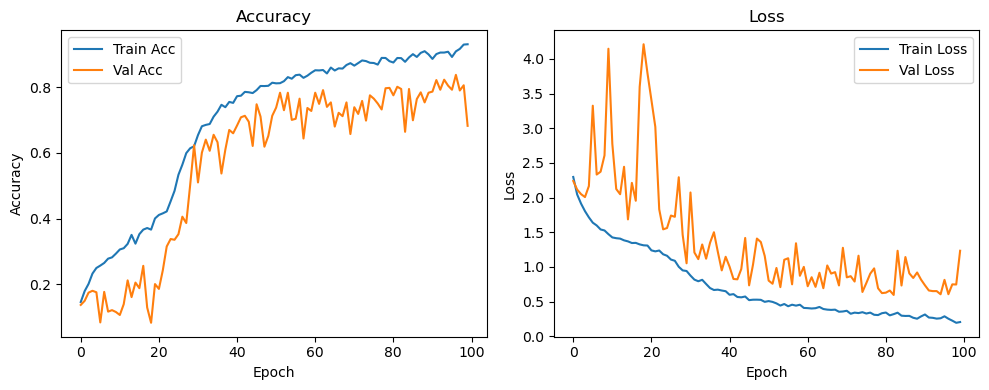

In [31]:
# 1. Plot training curves
def plot_training_curves(history):
    plt.figure(figsize=(10, 4))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_curves(history)

In [32]:
# 2. Classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
center,0.466667,0.666667,0.549020,42.000000
down,0.465116,0.476190,0.470588,42.000000
down_left,0.800000,0.920635,0.856089,126.000000
down_right,0.896226,0.748031,0.815451,127.000000
left,0.911504,0.817460,0.861925,126.000000
right,0.860870,0.785714,0.821577,126.000000
up,0.433333,0.928571,0.590909,42.000000
up_left,0.945455,0.825397,0.881356,126.000000
up_right,0.940594,0.753968,0.837004,126.000000
accuracy,0.791619,0.791619,0.791619,0.791619


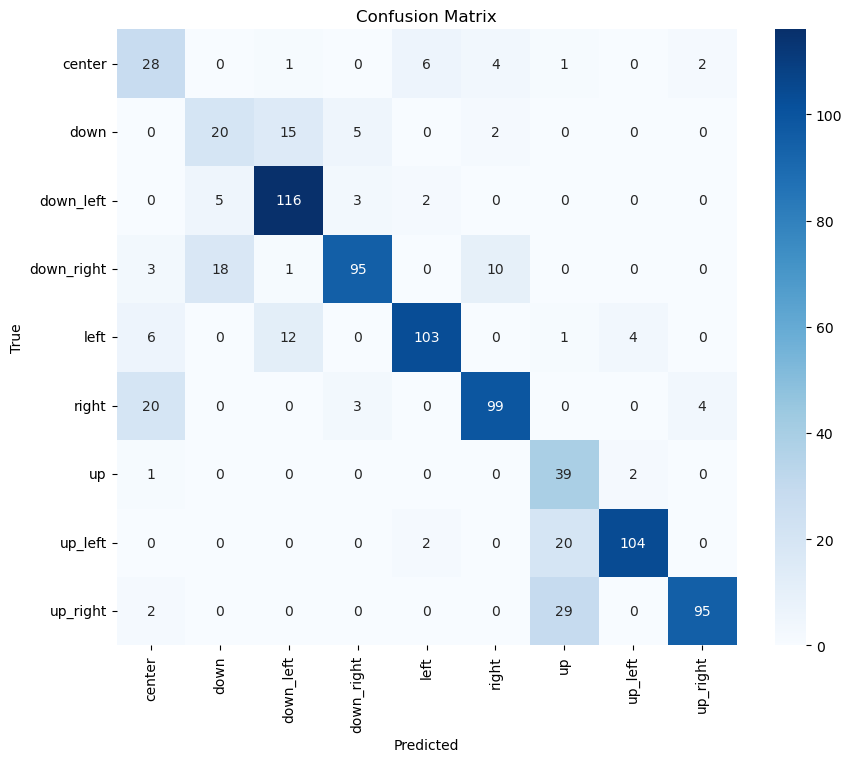

In [33]:
# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


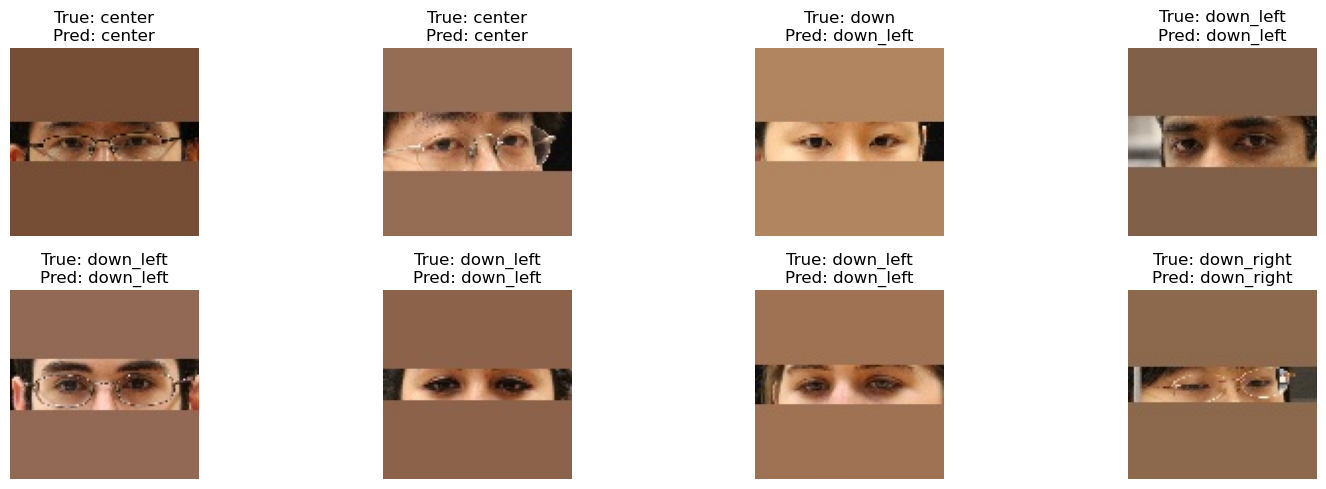

In [34]:
# 4. Inference examples
def plot_inference_examples(generator, y_pred, class_names, num_examples=8):
    fig, axes = plt.subplots(2, num_examples // 2, figsize=(16, 5))
    axes = axes.flatten()
    for i in range(num_examples):
        img, label = generator[i]
        pred_label = class_names[np.argmax(model.predict(np.expand_dims(img[0], axis=0)))]
        true_label = class_names[np.argmax(label[0])]
        axes[i].imshow(img[0])
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display
plot_inference_examples(test_gen, y_pred, class_names)